this notebook represent different implementations of the Genetic Algorithms using different variation of selection, crossover and mutation

#1. Reverse mutation and Ordered crossover

**Reverse Mutation**
Reverse mutation involves selecting a segment of a chromosome and reversing the order of its genes. This technique helps to maintain genetic diversity and can lead to the discovery of better solutions.

**Ordered Crossover**
Ordered crossover is a method used to create offspring by combining genes from two parent chromosomes while preserving the relative order of genes. This method is particularly useful in problems where the order of elements is important, such as sequencing tasks.

In [ ]:
import numpy as np
import pandas as pd
import random
import time

# Customers
total_customers = 11  # 10 customers plus one depot
demand_per_customer = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]

# Vehicles
number_of_vehicles = 6
max_vehicle_capacity = 100

# Distance Matrix
distance_data = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distance_df = pd.DataFrame(distance_data, index=range(1, 12), columns=range(1, 12))

# Genetic Algorithm Class

class VRPGeneticAlgorithm:

    def __init__(self, total_customers, max_vehicle_capacity, distance_matrix, demand_per_customer):
        self.total_customers = total_customers
        self.max_vehicle_capacity = max_vehicle_capacity
        self.distance_matrix = distance_matrix
        self.demand_per_customer = demand_per_customer

    def create_initial_population(self):
        population = []
        customers_to_visit = list(range(2, self.total_customers + 1))
        random.shuffle(customers_to_visit)
        while customers_to_visit:
            route = [1]  # Start at depot
            current_load = 0
            while customers_to_visit:
                next_customer = customers_to_visit[-1]
                if current_load + self.demand_per_customer[next_customer - 1] <= self.max_vehicle_capacity:
                    route.append(next_customer)
                    current_load += self.demand_per_customer[next_customer - 1]
                    customers_to_visit.pop()
                else:
                    break
            route.append(1)  # Return to depot
            population.append(route)
        return population

    def compute_route_cost(self, route):
        total_cost = 0
        current_load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i + 1]
            total_cost += self.distance_matrix[from_node - 1][to_node - 1]
            current_load += self.demand_per_customer[to_node - 1]
            if current_load > self.max_vehicle_capacity:
                total_cost += 1000  # Penalize for exceeding capacity
                current_load = 0
        return total_cost

    def compute_route_length(self, route):
        total_length = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i + 1]
            total_length += self.distance_matrix[from_node - 1][to_node - 1]
        return total_length

    def reverse_mutation(self, route):
        new_route = route[:]
        idx_range = range(1, len(new_route) - 1)
        if len(idx_range) < 2:
            return new_route  # No mutation possible
        idx1, idx2 = random.sample(idx_range, 2)  # Exclude depot index

        if idx1 > idx2:
            idx1, idx2 = idx2, idx1

        new_route = route[:idx1] + list(reversed(route[idx1:idx2 + 1])) + route[idx2 + 1:]

        current_demand = sum(self.demand_per_customer[customer - 1] for customer in new_route[1:-1])
        if current_demand > self.max_vehicle_capacity:
            return route  # Revert mutation if capacity is exceeded
        return new_route

    def order_crossover(self, parent1, parent2):
        size = len(parent1)
        idx1, idx2 = sorted(random.sample(range(size), 2))

        middle_segment = parent1[idx1:idx2]
        child = [-1] * size
        child[idx1:idx2] = middle_segment

        remaining_genes = [gene for gene in parent2 if gene not in middle_segment]
        j = idx2
        for gene in remaining_genes:
            if child[j % size] == -1:
                child[j % size] = gene
                j += 1

        return child

    def run_genetic_algorithm(self, population, num_generations):
        best_routes_list = []
        best_costs_list = []

        for generation in range(num_generations):
            new_population = []

            for routes in population:
                mutated_routes = []
                for route in routes:
                    mutated_route = self.reverse_mutation(route)
                    mutated_routes.append(mutated_route)
                new_population.append(mutated_routes)

            population = new_population

            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = population[i]
                    parent2 = population[i + 1]
                    child1 = self.order_crossover(parent1, parent2)
                    child2 = self.order_crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2

            all_routes = [route for routes in population for route in routes]
            all_costs = [self.compute_route_cost(route) for route in all_routes]

            generation_best_routes = []
            generation_best_costs = []
            for i in range(number_of_vehicles):
                vehicle_routes = all_routes[i::number_of_vehicles]
                vehicle_costs = all_costs[i::number_of_vehicles]
                if vehicle_costs:
                    best_route_index = np.argmin(vehicle_costs)
                    best_route = vehicle_routes[best_route_index]
                    best_cost = vehicle_costs[best_route_index]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)

            best_routes_list.append(generation_best_routes)
            best_costs_list.append(generation_best_costs)

        final_best_routes = [min(routes, key=self.compute_route_cost) for routes in zip(*best_routes_list)]
        final_best_costs = [self.compute_route_cost(route) for route in final_best_routes]

        return final_best_routes, final_best_costs

if __name__ == "__main__":

    vrp_ga = VRPGeneticAlgorithm(total_customers, max_vehicle_capacity, distance_data, demand_per_customer)

    lowest_total_cost = float('inf')

    num_iterations = 100
    sum_costs_all_runs = 0
    start_time = time.time()

    for _ in range(num_iterations):
        initial_population = vrp_ga.create_initial_population()
        optimal_routes, optimal_costs = vrp_ga.run_genetic_algorithm([initial_population], num_generations=1000)

        total_cost = sum(optimal_costs)
        sum_costs_all_runs += total_cost

        if total_cost < lowest_total_cost:
            lowest_total_cost = total_cost
            best_routes_with_lowest_cost = optimal_routes
            best_costs_with_lowest_cost = optimal_costs
    end_time = time.time()
    execution_time = end_time - start_time
    total_distance = 0
    for i in range(len(best_routes_with_lowest_cost)):
        route = best_routes_with_lowest_cost[i]
        load = sum(demand_per_customer[node - 1] for node in route[1:-1])
        length = vrp_ga.compute_route_length(route)
        total_distance += length
        print(f"Vehicle {i + 1} the tour is: {'-'.join(map(str, route))} total load is: {load}, the length is: {length}.")

    print(f"So the total distance for the used vehicles is {total_distance}.")
        # Print execution time
    print(f'Execution Time: {execution_time} seconds')


Vehicle 1 the tour is: 1-3-7-1 total load is: 85, the length is: 343.
Vehicle 2 the tour is: 1-5-8-9-1 total load is: 70, the length is: 382.
Vehicle 3 the tour is: 1-2-6-4-1 total load is: 100, the length is: 356.
Vehicle 4 the tour is: 1-11-10-1 total load is: 100, the length is: 499.
Vehicle 5 the tour is:  total load is: 0, the length is: 0.
Vehicle 6 the tour is:  total load is: 0, the length is: 0.
So the total distance for the used vehicles is 1580.
Execution Time: 6.94994330406189 seconds


#2. Tournament selection

Tournament selection is a method in genetic algorithms where a subset of individuals is randomly chosen from the population, their fitness levels are compared, and the best individual from this subset is selected as a parent. This process is repeated to select multiple parents, allowing for control over selection pressure and maintaining population diversity.

In [ ]:
import numpy as np
import pandas as pd
import random
import time

# Customers
total_customers = 11  # 10 customers plus one depot
demand_per_customer = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]

# Vehicles
number_of_vehicles = 6
max_vehicle_capacity = 100

# Distance Matrix
distance_data = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distance_df = pd.DataFrame(distance_data, index=range(1, 12), columns=range(1, 12))

# Genetic Algorithm Class
class VRPGeneticAlgorithm:

    def __init__(self, total_customers, max_vehicle_capacity, distance_matrix, demand_per_customer):
        self.total_customers = total_customers
        self.max_vehicle_capacity = max_vehicle_capacity
        self.distance_matrix = distance_matrix
        self.demand_per_customer = demand_per_customer

    def create_initial_population(self):
        population = []
        customers_to_visit = list(range(2, self.total_customers + 1))
        random.shuffle(customers_to_visit)
        while customers_to_visit:
            route = [1]  # Start at depot
            current_load = 0
            while customers_to_visit:
                next_customer = customers_to_visit[-1]
                if current_load + self.demand_per_customer[next_customer - 1] <= self.max_vehicle_capacity:
                    route.append(next_customer)
                    current_load += self.demand_per_customer[next_customer - 1]
                    customers_to_visit.pop()
                else:
                    break
            route.append(1)  # Return to depot
            population.append(route)
        return population

    def compute_route_cost(self, route):
        total_cost = 0
        current_load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i + 1]
            total_cost += self.distance_matrix[from_node - 1][to_node - 1]
            current_load += self.demand_per_customer[to_node - 1]
            if current_load > self.max_vehicle_capacity:
                total_cost += 1000  # Penalize for exceeding capacity
                current_load = 0
        return total_cost

    def compute_route_length(self, route):
        total_length = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i + 1]
            total_length += self.distance_matrix[from_node - 1][to_node - 1]
        return total_length

    def reverse_mutation(self, route):
        new_route = route[:]
        idx_range = range(1, len(new_route) - 1)
        if len(idx_range) < 2:
            return new_route  # No mutation possible
        idx1, idx2 = random.sample(idx_range, 2)  # Exclude depot index

        if idx1 > idx2:
            idx1, idx2 = idx2, idx1

        new_route = route[:idx1] + list(reversed(route[idx1:idx2 + 1])) + route[idx2 + 1:]

        current_demand = sum(self.demand_per_customer[customer - 1] for customer in new_route[1:-1])
        if current_demand > self.max_vehicle_capacity:
            return route  # Revert mutation if capacity is exceeded
        return new_route

    def order_crossover(self, parent1, parent2):
        size = len(parent1)
        idx1, idx2 = sorted(random.sample(range(size), 2))

        middle_segment = parent1[idx1:idx2]
        child = [-1] * size
        child[idx1:idx2] = middle_segment

        remaining_genes = [gene for gene in parent2 if gene not in middle_segment]
        j = idx2
        for gene in remaining_genes:
            if child[j % size] == -1:
                child[j % size] = gene
                j += 1

        return child

    def tournament_selection(self, population, k=3):
        tournament = random.sample(population, k)
        tournament_fitness = [(self.compute_route_cost(individual), individual) for individual in tournament]
        tournament_fitness.sort(key=lambda x: x[0])
        return tournament_fitness[0][1]

    def run_genetic_algorithm(self, population, num_generations):
        best_routes_list = []
        best_costs_list = []

        for generation in range(num_generations):
            new_population = []

            for routes in population:
                mutated_routes = []
                for route in routes:
                    mutated_route = self.reverse_mutation(route)
                    mutated_routes.append(mutated_route)
                new_population.append(mutated_routes)

            population = new_population

            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = self.tournament_selection(population)
                    parent2 = self.tournament_selection(population)
                    child1 = self.order_crossover(parent1, parent2)
                    child2 = self.order_crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2

            all_routes = [route for routes in population for route in routes]
            all_costs = [self.compute_route_cost(route) for route in all_routes]

            generation_best_routes = []
            generation_best_costs = []
            for i in range(number_of_vehicles):
                vehicle_routes = all_routes[i::number_of_vehicles]
                vehicle_costs = all_costs[i::number_of_vehicles]
                if vehicle_costs:
                    best_route_index = np.argmin(vehicle_costs)
                    best_route = vehicle_routes[best_route_index]
                    best_cost = vehicle_costs[best_route_index]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)

            best_routes_list.append(generation_best_routes)
            best_costs_list.append(generation_best_costs)

        final_best_routes = [min(routes, key=self.compute_route_cost) for routes in zip(*best_routes_list)]
        final_best_costs = [self.compute_route_cost(route) for route in final_best_routes]

        return final_best_routes, final_best_costs

if __name__ == "__main__":

    vrp_ga = VRPGeneticAlgorithm(total_customers, max_vehicle_capacity, distance_data, demand_per_customer)

    lowest_total_cost = float('inf')

    num_iterations = 100
    sum_costs_all_runs = 0
    start_time = time.time()


    for _ in range(num_iterations):
        initial_population = vrp_ga.create_initial_population()
        optimal_routes, optimal_costs = vrp_ga.run_genetic_algorithm([initial_population], num_generations=1000)

        total_cost = sum(optimal_costs)
        sum_costs_all_runs += total_cost

        if total_cost < lowest_total_cost:
            lowest_total_cost = total_cost
            best_routes_with_lowest_cost = optimal_routes
            best_costs_with_lowest_cost = optimal_costs
    end_time = time.time()
    execution_time = end_time - start_time

    total_distance = 0
    for i in range(len(best_routes_with_lowest_cost)):
        route = best_routes_with_lowest_cost[i]
        load = sum(demand_per_customer[node - 1] for node in route[1:-1])
        length = vrp_ga.compute_route_length(route)
        total_distance += length
        print(f"Vehicle {i + 1} the tour is: {'-'.join(map(str, route))} total load is: {load}, the length is: {length}.")



    print(f"So the total distance for the used vehicles is {total_distance}.")
            # Print execution time
    print(f'Execution Time: {execution_time} seconds')


Vehicle 1 the tour is: 1-7-5-1 total load is: 85, the length is: 374.
Vehicle 2 the tour is: 1-9-8-2-3-1 total load is: 75, the length is: 368.
Vehicle 3 the tour is: 1-11-10-1 total load is: 100, the length is: 499.
Vehicle 4 the tour is: 1-4-6-1 total load is: 95, the length is: 332.
Vehicle 5 the tour is:  total load is: 0, the length is: 0.
Vehicle 6 the tour is:  total load is: 0, the length is: 0.
So the total distance for the used vehicles is 1573.
Execution Time: 7.330642223358154 seconds


#3. Swap mutation and Partially Mapped Crossover


**Swap Mutation**
Swap mutation is a genetic algorithm technique where two randomly selected genes in a chromosome are swapped. This mutation helps introduce diversity into the population and can lead to new, potentially better solutions by altering the gene order without changing the overall composition.

**Partially Mapped Crossover (PMX)**
Partially Mapped Crossover (PMX) is a crossover method used in genetic algorithms, particularly for permutation-based problems. It works by selecting a segment from one parent and mapping it to a corresponding segment in the other parent, then filling the remaining positions with the unmapped genes while preserving their order and positions as much as possible. This helps maintain useful gene sequences and introduces new genetic combinations.

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
# customers
num_customers = 11  # 10 customers and one depot
customer_demands = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]
# vehicles
num_vehicles = 6
vehicle_capacity = 100
# Routes costs
distance_matrix = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378 ],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distances = pd.DataFrame(distance_matrix, index=range(1, 12), columns=range(1, 12))

# initialize the graph
G = nx.Graph()

# add nodes
for i in range(1, 12):
    G.add_node(i)

# add edges
for i in range(1, 12):
    for j in range(i + 1, 12):
        if distance_matrix[i-1][j-1] != 0:
            G.add_edge(i, j, weight=distance_matrix[i-1][j-1])




class GeneticAlgorithm:

    def __init__(self, num_customers, vehicle_capacity, distance_matrix, customer_demands):
        self.num_customers = num_customers
        self.vehicle_capacity = vehicle_capacity
        self.distance_matrix = distance_matrix
        self.customer_demands = customer_demands

    def initialize_population(self):
        population = []
        remaining_customers = list(range(2, self.num_customers + 1))
        random.shuffle(remaining_customers)
        while remaining_customers:
            route = [1]  # Start at depot
            load = 0
            while remaining_customers:
                next_customer = remaining_customers[-1]
                if load + self.customer_demands[next_customer - 1] <= self.vehicle_capacity:
                    route.append(next_customer)
                    load += self.customer_demands[next_customer - 1]
                    remaining_customers.pop()
                else:
                    break
            route.append(1)  # End at depot
            population.append(route)
        return population

    def evaluate_route(self, route):
        cost = 0
        load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i+1]
            cost += self.distance_matrix[from_node - 1][to_node - 1]
            load += self.customer_demands[to_node - 1]
            if load > self.vehicle_capacity:
                cost += 1000
                load = 0
        return cost

    # Swap mutation
    def mutate_route(self, route):
        mutated_route = route[:]
        idx_range = range(1, len(mutated_route) - 1)
        if len(idx_range) < 2:
            return mutated_route  # no mutation possible
        idx1, idx2 = random.sample(idx_range, 2) # exclude depot index
        mutated_route[idx1], mutated_route[idx2] = mutated_route[idx2], mutated_route[idx1]
        return mutated_route

    # Partially Mapped Crossover (PMX)
    def crossover(self, parent1, parent2):
        size = len(parent1)
        idx1, idx2 = sorted(random.sample(range(size), 2))

        # Copy middle segment from parent1 to child
        child = [None] * size
        child[idx1:idx2] = parent1[idx1:idx2]

        # Map elements from parent2 to child
        for i, gene in enumerate(parent2[idx1:idx2]):
            parent_gene = parent1[idx1 + i]
            while parent_gene in child:
                idx = parent2.index(parent_gene)
                parent_gene = parent1[idx]
            child[idx] = parent_gene

        # Fill in the remaining genes from parent2
        for i in range(size):
            if child[i] is None:
                child[i] = parent2[i]

        return child

    def genetic_algorithm(self, population, generations):
        best_routes = []
        best_costs = []

        for gen in range(generations):
            new_population = []

            # mutation
            for routes in population:
                new_routes = []
                for route in routes:
                    new_route = self.mutate_route(route)
                    new_routes.append(new_route)
                new_population.append(new_routes)

            population = new_population

            # crossover
            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = population[i]
                    parent2 = population[i + 1]
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2

            # evaluate population
            all_routes = [route for routes in population for route in routes]
            all_costs = [self.evaluate_route(route) for route in all_routes]

            # selection (finding the best route for each vehicle)
            generation_best_routes = []
            generation_best_costs = []
            for i in range(num_vehicles):
                routes_for_vehicle = all_routes[i::num_vehicles]
                costs_for_vehicle = all_costs[i::num_vehicles]
                if costs_for_vehicle:
                    best_route_idx = np.argmin(costs_for_vehicle)
                    best_route = routes_for_vehicle[best_route_idx]
                    best_cost = costs_for_vehicle[best_route_idx]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)

            best_routes.append(generation_best_routes)
            best_costs.append(generation_best_costs)

        # select the overall best routes and costs
        overall_best_routes = [min(routes, key=self.evaluate_route) for routes in zip(*best_routes)]
        overall_best_costs = [self.evaluate_route(route) for route in overall_best_routes]

        return overall_best_routes, overall_best_costs

if __name__ == "__main__":

    # an instance of the genetic algorithm class
    ga = GeneticAlgorithm(num_customers, vehicle_capacity, distance_matrix, customer_demands)

    min_total_cost = float('inf')  # initialize with infinity

    num_runs = 100  # number of iterations
    total_cost_for_all_runs = 0  # to calculate the average
    start_time = time.time()
    for _ in range(num_runs):
        # Initialize population
        population = ga.initialize_population()

        # run genetic algorithm
        best_routes, best_costs = ga.genetic_algorithm([population], generations=1000)

        # calculate total cost
        total_cost = sum(best_costs)
        total_cost_for_all_runs += total_cost

        # update minimum total cost and corresponding solution
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_routes_min_cost = best_routes
            best_costs_min_cost = best_costs

    end_time = time.time()
    execution_time = end_time - start_time

    # Print best routes and load for the solution with the minimum total cost
    total_distance_used_vehicles = 0
    for i in range(len(best_routes_min_cost)):
        route = best_routes_min_cost[i]
        load = sum(customer_demands[node - 1] for node in route[1:-1])  # Excluding depot nodes
        length = sum(distance_matrix[route[j] - 1][route[j + 1] - 1] for j in range(len(route) - 1))

        if load > 0:
            total_distance_used_vehicles += length
            print(f"Vehicle {i + 1} the tour is: {'-'.join(map(str, route))} total load is: {load}, the length is: {length}.")
        else:
            print(f"Vehicle {i + 1} the tour is:  total load is: {load}, the length is: {length}.")


    # Print total cost for the solution with the minimum total cost
    print(f"\nTotal Cost For The Best Solution is: {min_total_cost}")

    # Calculate and print average total cost
    average_total_cost = total_cost_for_all_runs / num_runs
    print(f"Average Total Cost of all trials: {average_total_cost}")

    # Print total distance for the used vehicles
    print(f"So the total distance for the used vehicles is {total_distance_used_vehicles}.")

    # Print execution time
    print(f'Execution Time: {execution_time} seconds')



Vehicle 1 the tour is: 1-6-1 total load is: 85, the length is: 328.
Vehicle 2 the tour is: 1-2-3-5-9-8-1 total load is: 95, the length is: 410.
Vehicle 3 the tour is: 1-10-11-1 total load is: 100, the length is: 499.
Vehicle 4 the tour is: 1-7-4-1 total load is: 75, the length is: 336.
Vehicle 5 the tour is:  total load is: 0, the length is: 0.
Vehicle 6 the tour is:  total load is: 0, the length is: 0.

Total Cost For The Best Solution is: 1573
Average Total Cost of all trials: 2158.14
So the total distance for the used vehicles is 1573.
Execution Time: 6.850506782531738 seconds


#4.  Inverse mutation and uniform crossover

**Inverse Mutation**
Inverse mutation is a genetic algorithm technique where a segment of a chromosome is selected and its order is reversed. This mutation helps to increase genetic diversity and can potentially uncover better solutions by altering the arrangement of genes in a meaningful way.

**Uniform Crossover**
Uniform crossover is a crossover method in genetic algorithms where genes from two parent chromosomes are randomly chosen with equal probability to create offspring. Each gene in the offspring is independently selected from either parent, leading to a high level of genetic mixing and allowing for diverse and potentially effective combinations of traits.

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
# customers
num_customers = 11  # 10 customers and one depot
customer_demands = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]
# vehicles
num_vehicles = 6
vehicle_capacity = 100
# Routes costs
distance_matrix = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378 ],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distances = pd.DataFrame(distance_matrix, index=range(1, 12), columns=range(1, 12))

# initialize the graph
G = nx.Graph()

# add nodes
for i in range(1, 12):
    G.add_node(i)

# add edges
for i in range(1, 12):
    for j in range(i + 1, 12):
        if distance_matrix[i-1][j-1] != 0:
            G.add_edge(i, j, weight=distance_matrix[i-1][j-1])




class GeneticAlgorithm:

    def __init__(self, num_customers, vehicle_capacity, distance_matrix, customer_demands):
        self.num_customers = num_customers
        self.vehicle_capacity = vehicle_capacity
        self.distance_matrix = distance_matrix
        self.customer_demands = customer_demands

    def initialize_population(self):
        population = []
        remaining_customers = list(range(2, self.num_customers + 1))
        random.shuffle(remaining_customers)
        while remaining_customers:
            route = [1]  # Start at depot
            load = 0
            while remaining_customers:
                next_customer = remaining_customers[-1]
                if load + self.customer_demands[next_customer - 1] <= self.vehicle_capacity:
                    route.append(next_customer)
                    load += self.customer_demands[next_customer - 1]
                    remaining_customers.pop()
                else:
                    break
            route.append(1)  # End at depot
            population.append(route)
        return population

    def evaluate_route(self, route):
        cost = 0
        load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i+1]
            cost += self.distance_matrix[from_node - 1][to_node - 1]
            load += self.customer_demands[to_node - 1]
            if load > self.vehicle_capacity:
                cost += 1000
                load = 0
        return cost

    # Inversion Mutation
    def mutate_route(self, route):
        mutated_route = route[:]
        idx_range = range(1, len(mutated_route) - 1)
        if len(idx_range) < 2:
            return mutated_route  # no mutation possible
        idx1, idx2 = random.sample(idx_range, 2) # exclude depot index
        idx1, idx2 = min(idx1, idx2), max(idx1, idx2)
        mutated_route[idx1:idx2+1] = reversed(mutated_route[idx1:idx2+1])
        return mutated_route

    # Uniform Crossover
    def crossover(self, parent1, parent2):
        size = len(parent1)
        child = [None] * size
        for i in range(size):
            if random.random() < 0.5:
                child[i] = parent1[i]
            else:
                child[i] = parent2[i]
        return child

    def genetic_algorithm(self, population, generations):
        best_routes = []
        best_costs = []

        for gen in range(generations):
            new_population = []

            # mutation
            for routes in population:
                new_routes = []
                for route in routes:
                    new_route = self.mutate_route(route)
                    new_routes.append(new_route)
                new_population.append(new_routes)

            population = new_population

            # crossover
            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = population[i]
                    parent2 = population[i + 1]
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2

            # evaluate population
            all_routes = [route for routes in population for route in routes]
            all_costs = [self.evaluate_route(route) for route in all_routes]

            # selection (finding the best route for each vehicle)
            generation_best_routes = []
            generation_best_costs = []
            for i in range(num_vehicles):
                routes_for_vehicle = all_routes[i::num_vehicles]
                costs_for_vehicle = all_costs[i::num_vehicles]
                if costs_for_vehicle:
                    best_route_idx = np.argmin(costs_for_vehicle)
                    best_route = routes_for_vehicle[best_route_idx]
                    best_cost = costs_for_vehicle[best_route_idx]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)

            best_routes.append(generation_best_routes)
            best_costs.append(generation_best_costs)

        # select the overall best routes and costs
        overall_best_routes = [min(routes, key=self.evaluate_route) for routes in zip(*best_routes)]
        overall_best_costs = [self.evaluate_route(route) for route in overall_best_routes]

        return overall_best_routes, overall_best_costs

if __name__ == "__main__":

    # an instance of the genetic algorithm class
    ga = GeneticAlgorithm(num_customers, vehicle_capacity, distance_matrix, customer_demands)

    min_total_cost = float('inf')  # initialize with infinity

    num_runs = 100  # number of iterations
    total_cost_for_all_runs = 0  # to calculate the average
    start_time = time.time()
    for _ in range(num_runs):
        # Initialize population
        population = ga.initialize_population()

        # run genetic algorithm
        best_routes, best_costs = ga.genetic_algorithm([population], generations=1000)

        # calculate total cost
        total_cost = sum(best_costs)
        total_cost_for_all_runs += total_cost

        # update minimum total cost and corresponding solution
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_routes_min_cost = best_routes
            best_costs_min_cost = best_costs

    end_time = time.time()
    execution_time = end_time - start_time

    # Print best routes and load for the solution with the minimum total cost
    total_distance_used_vehicles = 0
    for i in range(len(best_routes_min_cost)):
        route = best_routes_min_cost[i]
        load = sum(customer_demands[node - 1] for node in route[1:-1])  # Excluding depot nodes
        length = sum(distance_matrix[route[j] - 1][route[j + 1] - 1] for j in range(len(route) - 1))

        if load > 0:
            total_distance_used_vehicles += length
            print(f"Vehicle {i + 1} the tour is: {'-'.join(map(str, route))} total load is: {load}, the length is: {length}.")
        else:
            print(f"Vehicle {i + 1} the tour is:  total load is: {load}, the length is: {length}.")

    # Print total cost for the solution with the minimum total cost
    print(f"\nTotal Cost For The Best Solution is: {min_total_cost}")

    # Calculate and print average total cost
    average_total_cost = total_cost_for_all_runs / num_runs
    print(f"Average Total Cost of all trials: {average_total_cost}")

    # Print total distance for the used vehicles
    print(f"So the total distance for the used vehicles is {total_distance_used_vehicles}.")

    # Print execution time
    print(f'Execution Time: {execution_time} seconds')




Vehicle 1 the tour is: 1-10-11-1 total load is: 100, the length is: 499.
Vehicle 2 the tour is: 1-8-5-3-2-1 total load is: 75, the length is: 406.
Vehicle 3 the tour is: 1-9-7-1 total load is: 85, the length is: 342.
Vehicle 4 the tour is: 1-4-6-1 total load is: 95, the length is: 332.
Vehicle 5 the tour is:  total load is: 0, the length is: 0.
Vehicle 6 the tour is:  total load is: 0, the length is: 0.

Total Cost For The Best Solution is: 1579
Average Total Cost of all trials: 2184.46
So the total distance for the used vehicles is 1579.
Execution Time: 7.396810293197632 seconds


#5. scranble mutation and Edge Recombination Crossover

**Scramble Mutation**
Scramble mutation is a genetic algorithm technique where a subset of genes within a chromosome is randomly shuffled. This mutation increases genetic diversity by changing the order of the genes in the selected segment while keeping the same set of genes.

**Edge Recombination Crossover**
Edge Recombination Crossover (ERX) is a crossover method used in genetic algorithms for permutation-based problems, like the Traveling Salesman Problem. It constructs offspring by considering the edges (connections between genes) present in the parent chromosomes. The algorithm builds a table of edges for each gene based on its neighbors in both parents, then systematically selects edges that maintain as many parent connections as possible, thus preserving beneficial gene sequences and their relationships.

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
# customers
num_customers = 11  # 10 customers and one depot
customer_demands = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]
# vehicles
num_vehicles = 6
vehicle_capacity = 100
# Routes costs
distance_matrix = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378 ],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distances = pd.DataFrame(distance_matrix, index=range(1, 12), columns=range(1, 12))

# initialize the graph
G = nx.Graph()

# add nodes
for i in range(1, 12):
    G.add_node(i)

# add edges
for i in range(1, 12):
    for j in range(i + 1, 12):
        if distance_matrix[i-1][j-1] != 0:
            G.add_edge(i, j, weight=distance_matrix[i-1][j-1])




class GeneticAlgorithm:

    def __init__(self, num_customers, vehicle_capacity, distance_matrix, customer_demands):
        self.num_customers = num_customers
        self.vehicle_capacity = vehicle_capacity
        self.distance_matrix = distance_matrix
        self.customer_demands = customer_demands

    def initialize_population(self):
        population = []
        remaining_customers = list(range(2, self.num_customers + 1))
        random.shuffle(remaining_customers)
        while remaining_customers:
            route = [1]  # Start at depot
            load = 0
            while remaining_customers:
                next_customer = remaining_customers[-1]
                if load + self.customer_demands[next_customer - 1] <= self.vehicle_capacity:
                    route.append(next_customer)
                    load += self.customer_demands[next_customer - 1]
                    remaining_customers.pop()
                else:
                    break
            route.append(1)  # End at depot
            population.append(route)
        return population

    def evaluate_route(self, route):
        cost = 0
        load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i+1]
            cost += self.distance_matrix[from_node - 1][to_node - 1]
            load += self.customer_demands[to_node - 1]
            if load > self.vehicle_capacity:
                cost += 1000
                load = 0
        return cost

    # Scramble Mutation
    def mutate_route(self, route):
        mutated_route = route[:]
        idx_range = range(1, len(mutated_route) - 1)
        if len(idx_range) < 2:
            return mutated_route  # no mutation possible
        idx1, idx2 = random.sample(idx_range, 2) # exclude depot index
        if idx1 > idx2:
            idx1, idx2 = idx2, idx1
        segment = mutated_route[idx1:idx2+1]
        random.shuffle(segment)
        mutated_route[idx1:idx2+1] = segment
        return mutated_route

    # Edge Recombination Crossover (ERX)
    def crossover(self, parent1, parent2):
        size = len(parent1)
        child = [None] * size
        edges = {}
        for i in range(size):
            edges[parent1[i]] = set([parent1[(i-1)%size], parent1[(i+1)%size]])
            edges[parent2[i]] = set([parent2[(i-1)%size], parent2[(i+1)%size]])

        current_node = random.choice(parent1)
        while None in child:
            child[child.index(None)] = current_node
            for node in edges:
                edges[node] -= {current_node}
            edges[current_node] = set()
            next_nodes = [node for node in edges[current_node] if node not in child]
            if next_nodes:
                current_node = next_nodes[0]
            else:
                unused_nodes = [node for node in parent1 if node not in child]
                if unused_nodes:
                    current_node = random.choice(unused_nodes)
                else:
                    break
        return child

    def genetic_algorithm(self, population, generations):
        best_routes = []
        best_costs = []

        for gen in range(generations):
            new_population = []

            # mutation
            for routes in population:
                new_routes = []
                for route in routes:
                    new_route = self.mutate_route(route)
                    new_routes.append(new_route)
                new_population.append(new_routes)

            population = new_population

            # crossover
            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = population[i]
                    parent2 = population[i + 1]
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2

            # evaluate population
            all_routes = [route for routes in population for route in routes]
            all_costs = [self.evaluate_route(route) for route in all_routes]

            # selection (finding the best route for each vehicle)
            generation_best_routes = []
            generation_best_costs = []
            for i in range(num_vehicles):
                routes_for_vehicle = all_routes[i::num_vehicles]
                costs_for_vehicle = all_costs[i::num_vehicles]
                if costs_for_vehicle:
                    best_route_idx = np.argmin(costs_for_vehicle)
                    best_route = routes_for_vehicle[best_route_idx]
                    best_cost = costs_for_vehicle[best_route_idx]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)

            best_routes.append(generation_best_routes)
            best_costs.append(generation_best_costs)

        # select the overall best routes and costs
        overall_best_routes = [min(routes, key=self.evaluate_route) for routes in zip(*best_routes)]
        overall_best_costs = [self.evaluate_route(route) for route in overall_best_routes]

        return overall_best_routes, overall_best_costs

if __name__ == "__main__":

    # an instance of the genetic algorithm class
    ga = GeneticAlgorithm(num_customers, vehicle_capacity, distance_matrix, customer_demands)

    min_total_cost = float('inf')  # initialize with infinity

    num_runs = 100  # number of iterations
    total_cost_for_all_runs = 0  # to calculate the average
    start_time = time.time()
    for _ in range(num_runs):
        # Initialize population
        population = ga.initialize_population()

        # run genetic algorithm
        best_routes, best_costs = ga.genetic_algorithm([population], generations=1000)

        # calculate total cost
        total_cost = sum(best_costs)
        total_cost_for_all_runs += total_cost

        # update minimum total cost and corresponding solution
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_routes_min_cost = best_routes
            best_costs_min_cost = best_costs

    end_time = time.time()
    execution_time = end_time - start_time

    # Print best routes and load for the solution with the minimum total cost
    total_distance_used_vehicles = 0
    for i in range(len(best_routes_min_cost)):
        route = best_routes_min_cost[i]
        load = sum(customer_demands[node - 1] for node in route[1:-1])  # Excluding depot nodes
        length = sum(distance_matrix[route[j] - 1][route[j + 1] - 1] for j in range(len(route) - 1))

        if load > 0:
            total_distance_used_vehicles += length
            print(f"Vehicle {i + 1} the tour is: {'-'.join(map(str, route))} total load is: {load}, the length is: {length}.")
        else:
            print(f"Vehicle {i + 1} the tour is:  total load is: {load}, the length is: {length}.")

    # Print total cost for the solution with the minimum total cost
    print(f"\nTotal Cost For The Best Solution is: {min_total_cost}")

    # Calculate and print average total cost
    average_total_cost = total_cost_for_all_runs / num_runs
    print(f"Average Total Cost of all trials: {average_total_cost}")

    # Print total distance for the used vehicles
    print(f"So the total distance for the used vehicles is {total_distance_used_vehicles}.")

    # Print execution time
    print(f'Execution Time: {execution_time} seconds')



Vehicle 1 the tour is: 1-7-1 total load is: 65, the length is: 332.
Vehicle 2 the tour is: 1-11-10-1 total load is: 100, the length is: 499.
Vehicle 3 the tour is: 1-5-8-9-4-1 total load is: 80, the length is: 385.
Vehicle 4 the tour is: 1-2-6-1 total load is: 90, the length is: 352.
Vehicle 5 the tour is: 1-3-1 total load is: 20, the length is: 12.
Vehicle 6 the tour is:  total load is: 0, the length is: 0.

Total Cost For The Best Solution is: 1580
Average Total Cost of all trials: 2179.27
So the total distance for the used vehicles is 1580.
Execution Time: 6.8028998374938965 seconds


#6. Partially Mapped Crossover (PMX), tournment selection and swap mutation

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
# customers
num_customers = 11  # 10 customers and one depot
customer_demands = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]
# vehicles
num_vehicles = 6
vehicle_capacity = 100
# Routes costs
distance_matrix = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378 ],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distances = pd.DataFrame(distance_matrix, index=range(1, 12), columns=range(1, 12))

# initialize the graph
G = nx.Graph()

# add nodes
for i in range(1, 12):
    G.add_node(i)

# add edges
for i in range(1, 12):
    for j in range(i + 1, 12):
        if distance_matrix[i-1][j-1] != 0:
            G.add_edge(i, j, weight=distance_matrix[i-1][j-1])




class GeneticAlgorithm:

    def __init__(self, num_customers, vehicle_capacity, distance_matrix, customer_demands):
        self.num_customers = num_customers
        self.vehicle_capacity = vehicle_capacity
        self.distance_matrix = distance_matrix
        self.customer_demands = customer_demands

    def initialize_population(self):
        population = []
        remaining_customers = list(range(2, self.num_customers + 1))
        random.shuffle(remaining_customers)
        while remaining_customers:
            route = [1]  # Start at depot
            load = 0
            while remaining_customers:
                next_customer = remaining_customers[-1]
                if load + self.customer_demands[next_customer - 1] <= self.vehicle_capacity:
                    route.append(next_customer)
                    load += self.customer_demands[next_customer - 1]
                    remaining_customers.pop()
                else:
                    break
            route.append(1)  # End at depot
            population.append(route)
        return population

    def evaluate_route(self, route):
        cost = 0
        load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i+1]
            cost += self.distance_matrix[from_node - 1][to_node - 1]
            load += self.customer_demands[to_node - 1]
            if load > self.vehicle_capacity:
                cost += 1000
                load = 0
        return cost
    # Tournament Selection
    def select_parents(self, population, tournament_size=3):
        selected_parents = []
        for _ in range(len(population)):
            # Ensure tournament size is valid
            actual_tournament_size = max(1, min(tournament_size, len(population)))
            tournament = random.sample(population, actual_tournament_size)
            best_parent = min(tournament, key=lambda x: self.evaluate_route(x))
            selected_parents.append(best_parent)
        return selected_parents


    # Partially Mapped Crossover (PMX)
    def crossover(self, parent1, parent2):
        size = len(parent1)
        child = [None] * size

        # Select random crossover points
        idx1, idx2 = sorted(random.sample(range(size), 2))

        # Copy the segment between crossover points from the first parent to the child
        child[idx1:idx2] = parent1[idx1:idx2]

        # Map genes from the second parent to the child
        mapping = {parent1[i]: parent2[i] for i in range(idx1, idx2)}
        for i in range(idx1, idx2):
            if parent2[i] not in child:
                next_gene = parent2[i]
                while next_gene in mapping:
                    next_gene = mapping[next_gene]
                child[child.index(None)] = next_gene

        # Fill in remaining genes from the second parent
        for i in range(size):
            if child[i] is None:
                child[i] = parent2[i]

        return child

    def mutate_route(self, route):
        mutated_route = route[:]
        size = len(mutated_route)
        valid_indices = [idx for idx in range(1, size - 1) if mutated_route[idx] != 1]  # Exclude depot indices
        if len(valid_indices) < 2:
            return mutated_route  # No valid indices to swap, return original route
        idx1, idx2 = random.sample(valid_indices, 2)
        mutated_route[idx1], mutated_route[idx2] = mutated_route[idx2], mutated_route[idx1]
        return mutated_route


    def genetic_algorithm(self, population, generations):
        best_routes = []
        best_costs = []

        for gen in range(generations):
            new_population = []

            # mutation
            for routes in population:
                new_routes = []
                for route in routes:
                    new_route = self.mutate_route(route)
                    new_routes.append(new_route)
                new_population.append(new_routes)

            population = new_population

            # crossover
            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = population[i]
                    parent2 = population[i + 1]
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2

            # evaluate population
            all_routes = [route for routes in population for route in routes]
            all_costs = [self.evaluate_route(route) for route in all_routes]

            # selection (finding the best route for each vehicle)
            generation_best_routes = []
            generation_best_costs = []
            for i in range(num_vehicles):
                routes_for_vehicle = all_routes[i::num_vehicles]
                costs_for_vehicle = all_costs[i::num_vehicles]
                if costs_for_vehicle:
                    best_route_idx = np.argmin(costs_for_vehicle)
                    best_route = routes_for_vehicle[best_route_idx]
                    best_cost = costs_for_vehicle[best_route_idx]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)

            best_routes.append(generation_best_routes)
            best_costs.append(generation_best_costs)

        # select the overall best routes and costs
        overall_best_routes = [min(routes, key=self.evaluate_route) for routes in zip(*best_routes)]
        overall_best_costs = [self.evaluate_route(route) for route in overall_best_routes]

        return overall_best_routes, overall_best_costs

if __name__ == "__main__":

    # an instance of the genetic algorithm class
    ga = GeneticAlgorithm(num_customers, vehicle_capacity, distance_matrix, customer_demands)

    min_total_cost = float('inf')  # initialize with infinity

    num_runs = 100  # number of iterations
    total_cost_for_all_runs = 0  # to calculate the average
    start_time = time.time()
    for _ in range(num_runs):
        # Initialize population
        population = ga.initialize_population()

        # run genetic algorithm
        best_routes, best_costs = ga.genetic_algorithm([population], generations=1000)

        # calculate total cost
        total_cost = sum(best_costs)
        total_cost_for_all_runs += total_cost

        # update minimum total cost and corresponding solution
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_routes_min_cost = best_routes
            best_costs_min_cost = best_costs

    end_time = time.time()
    execution_time = end_time - start_time

    # Print best routes and load for the solution with the minimum total cost
    total_distance_used_vehicles = 0
    for i in range(len(best_routes_min_cost)):
        route = best_routes_min_cost[i]
        load = sum(customer_demands[node - 1] for node in route[1:-1])  # Excluding depot nodes
        length = sum(distance_matrix[route[j] - 1][route[j + 1] - 1] for j in range(len(route) - 1))

        if load > 0:
            total_distance_used_vehicles += length
            print(f"Vehicle {i + 1} the tour is: {'-'.join(map(str, route))} total load is: {load}, the length is: {length}.")
        else:
            print(f"Vehicle {i + 1} the tour is:  total load is: {load}, the length is: {length}.")

    # Print total cost for the solution with the minimum total cost
    print(f"\nTotal Cost For The Best Solution is: {min_total_cost}")

    # Calculate and print average total cost
    average_total_cost = total_cost_for_all_runs / num_runs
    print(f"Average Total Cost of all trials: {average_total_cost}")

    # Print total distance for the used vehicles
    print(f"So the total distance for the used vehicles is {total_distance_used_vehicles}.")

    # Print execution time
    print(f'Execution Time: {execution_time} seconds')




Vehicle 1 the tour is: 1-6-1 total load is: 85, the length is: 328.
Vehicle 2 the tour is: 1-3-2-4-9-8-1 total load is: 85, the length is: 371.
Vehicle 3 the tour is: 1-7-5-1 total load is: 85, the length is: 374.
Vehicle 4 the tour is: 1-10-11-1 total load is: 100, the length is: 499.
Vehicle 5 the tour is:  total load is: 0, the length is: 0.
Vehicle 6 the tour is:  total load is: 0, the length is: 0.

Total Cost For The Best Solution is: 1572
Average Total Cost of all trials: 2177.03
So the total distance for the used vehicles is 1572.
Execution Time: 6.590245008468628 seconds


#7.  Uniform Crossover and Scramble Mutation

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import time

# Customers
num_customers = 11  # 10 customers and one depot
customer_demands = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]

# Vehicles
num_vehicles = 6
vehicle_capacity = 100

# Distance matrix
distance_matrix = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distances = pd.DataFrame(distance_matrix, index=range(1, 12), columns=range(1, 12))

# Initialize the graph
G = nx.Graph()

# Add nodes
for i in range(1, 12):
    G.add_node(i)

# Add edges
for i in range(1, 12):
    for j in range(i + 1, 12):
        if distance_matrix[i-1][j-1] != 0:
            G.add_edge(i, j, weight=distance_matrix[i-1][j-1])


class GeneticAlgorithm:
    def __init__(self, num_customers, vehicle_capacity, distance_matrix, customer_demands):
        self.num_customers = num_customers
        self.vehicle_capacity = vehicle_capacity
        self.distance_matrix = distance_matrix
        self.customer_demands = customer_demands

    def initialize_population(self):
        population = []
        remaining_customers = list(range(2, self.num_customers + 1))
        random.shuffle(remaining_customers)
        while remaining_customers:
            route = [1]  # Start at depot
            load = 0
            while remaining_customers:
                next_customer = remaining_customers[-1]
                if load + self.customer_demands[next_customer - 1] <= self.vehicle_capacity:
                    route.append(next_customer)
                    load += self.customer_demands[next_customer - 1]
                    remaining_customers.pop()
                else:
                    break
            route.append(1)  # End at depot
            population.append(route)
        return population

    def evaluate_route(self, route):
        cost = 0
        load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i+1]
            cost += self.distance_matrix[from_node - 1][to_node - 1]
            load += self.customer_demands[to_node - 1]
            if load > self.vehicle_capacity:
                cost += 1000
                load = 0
        return cost

    # Tournament Selection
    def select_parents(self, population, tournament_size=3):
        selected_parents = []
        for _ in range(len(population)):
            # Ensure tournament size is valid
            actual_tournament_size = max(1, min(tournament_size, len(population)))
            tournament = random.sample(population, actual_tournament_size)
            best_parent = min(tournament, key=lambda x: self.evaluate_route(x))
            selected_parents.append(best_parent)
        return selected_parents

    # Uniform Crossover
    def crossover(self, parent1, parent2):
        size = len(parent1)
        child = [-1] * size  # Placeholder for child
        genes_from_p1 = random.sample(range(size), size // 2)  # Randomly select genes from parent1

        for i in genes_from_p1:
            child[i] = parent1[i]

        p2_index = 0
        for i in range(size):
            if child[i] == -1:
                while parent2[p2_index] in child:
                    p2_index += 1
                child[i] = parent2[p2_index]

        return child

    # Scramble Mutation
    def mutate_route(self, route):
        mutated_route = route[:]
        size = len(mutated_route)
        valid_indices = [idx for idx in range(1, size - 1) if mutated_route[idx] != 1]  # Exclude depot indices
        if len(valid_indices) < 2:
            return mutated_route  # No valid indices to scramble, return original route
        idx1, idx2 = sorted(random.sample(valid_indices, 2))
        subset = mutated_route[idx1:idx2]
        random.shuffle(subset)
        mutated_route[idx1:idx2] = subset
        return mutated_route

    def genetic_algorithm(self, population, generations):
        best_routes = []
        best_costs = []

        for gen in range(generations):
            new_population = []

            # Mutation
            for routes in population:
                new_routes = []
                for route in routes:
                    new_route = self.mutate_route(route)
                    new_routes.append(new_route)
                new_population.append(new_routes)

            population = new_population

            # Crossover
            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = population[i]
                    parent2 = population[i + 1]
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2

            # Evaluate population
            all_routes = [route for routes in population for route in routes]
            all_costs = [self.evaluate_route(route) for route in all_routes]

            # Selection (finding the best route for each vehicle)
            generation_best_routes = []
            generation_best_costs = []
            for i in range(num_vehicles):
                routes_for_vehicle = all_routes[i::num_vehicles]
                costs_for_vehicle = all_costs[i::num_vehicles]
                if costs_for_vehicle:
                    best_route_idx = np.argmin(costs_for_vehicle)
                    best_route = routes_for_vehicle[best_route_idx]
                    best_cost = costs_for_vehicle[best_route_idx]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)

            best_routes.append(generation_best_routes)
            best_costs.append(generation_best_costs)

        # Select the overall best routes and costs
        overall_best_routes = [min(routes, key=self.evaluate_route) for routes in zip(*best_routes)]
        overall_best_costs = [self.evaluate_route(route) for route in overall_best_routes]

        return overall_best_routes, overall_best_costs


if __name__ == "__main__":

    # an instance of the genetic algorithm class
    ga = GeneticAlgorithm(num_customers, vehicle_capacity, distance_matrix, customer_demands)

    min_total_cost = float('inf')  # initialize with infinity

    num_runs = 100  # number of iterations
    total_cost_for_all_runs = 0  # to calculate the average
    start_time = time.time()
    for _ in range(num_runs):
        # Initialize population
        population = ga.initialize_population()

        # run genetic algorithm
        best_routes, best_costs = ga.genetic_algorithm([population], generations=1000)

        # calculate total cost
        total_cost = sum(best_costs)
        total_cost_for_all_runs += total_cost

        # update minimum total cost and corresponding solution
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_routes_min_cost = best_routes
            best_costs_min_cost = best_costs

    end_time = time.time()
    execution_time = end_time - start_time

    # Print best routes and load for the solution with the minimum total cost
    total_distance_used_vehicles = 0
    for i in range(len(best_routes_min_cost)):
        route = best_routes_min_cost[i]
        load = sum(customer_demands[node - 1] for node in route[1:-1])  # Excluding depot nodes
        length = sum(distance_matrix[route[j] - 1][route[j + 1] - 1] for j in range(len(route) - 1))

        if load > 0:
            total_distance_used_vehicles += length
            print(f"Vehicle {i + 1} the tour is: {'-'.join(map(str, route))} total load is: {load}, the length is: {length}.")
        else:
            print(f"Vehicle {i + 1} the tour is:  total load is: {load}, the length is: {length}.")

    # Print total cost for the solution with the minimum total cost
    print(f"\nTotal Cost For The Best Solution is: {min_total_cost}")

    # Calculate and print average total cost
    average_total_cost = total_cost_for_all_runs / num_runs
    print(f"Average Total Cost of all trials: {average_total_cost}")

    # Print total distance for the used vehicles
    print(f"So the total distance for the used vehicles is {total_distance_used_vehicles}.")

    # Print execution time
    print(f'Execution Time: {execution_time} seconds')



Vehicle 1 the tour is: 1-2-3-5-8-4-1 total load is: 85, the length is: 410.
Vehicle 2 the tour is: 1-10-11-1 total load is: 100, the length is: 499.
Vehicle 3 the tour is: 1-9-7-1 total load is: 85, the length is: 342.
Vehicle 4 the tour is: 1-6-1 total load is: 85, the length is: 328.
Vehicle 5 the tour is:  total load is: 0, the length is: 0.
Vehicle 6 the tour is:  total load is: 0, the length is: 0.

Total Cost For The Best Solution is: 1579
Average Total Cost of all trials: 2172.93
So the total distance for the used vehicles is 1579.
Execution Time: 7.092252254486084 seconds


#8. Genetic Algorithm Analysis for CVRP

### Solution Feasibility:
- **Load Capacity:** Each vehicle's load remains within the 100-unit capacity limit, ensuring feasible solutions.
- **Customer Service:** All customers are serviced exactly once, adhering to problem constraints.

### Cost Efficiency:
- **Total Cost:** The total cost represents the cumulative distance covered by all vehicles, with the genetic algorithm selecting the best solution from the population.
- **Variability:** The best solutions vary with each execution due to the genetic algorithm's inherent randomness in initialization, mutation, and crossover.
- **Statistics:** Over 100 iterations, the average total cost is approximately 2100, with the minimum observed cost being 1572.

### Algorithm Performance:
- The genetic algorithm effectively manages the combinatorial complexity of the CVRP, providing feasible and efficient solutions within constraints and in a reasonable timeframe.

### Possible Improvements:
- **Alternative Techniques:** Techniques such as COA (Crowding Optimization Algorithm) or hybrid methods could enhance solution quality.
- **Trial-and-Error:** Given the NP-hard nature of the problem, a trial-and-error approach is necessary to identify the best algorithm for a specific number of cities/customers.

### Comparison of Different Implementations:

1. **Reverse Mutation and Ordered Crossover**
   - **Total Distance:** 1580
   - **Execution Time:** 6.95 seconds

2. **Tournament Selection**
   - **Total Distance:** 1573
   - **Execution Time:** 7.33 seconds

3. **Swap Mutation and Partially Mapped Crossover**
   - **Total Distance:** 1573
   - **Execution Time:** 6.85 seconds

4. **Inverse Mutation and Uniform Crossover**
   - **Total Distance:** 1579
   - **Execution Time:** 7.40 seconds

5. **Scramble Mutation and Edge Recombination Crossover**

   - **Total Distance:** 1580
   - **Execution Time:** 6.80 seconds

6. **Partially Mapped Crossover (PMX) and Tournament Selection**

   - **Total Distance:** 1572
   - **Execution Time:** 6.59 seconds

7. **Uniform Crossover and Scramble Mutation**

   - **Total Distance:** 1579
   - **Execution Time:** 7.09 seconds

### Conclusion:
- **Best Implementation:** The combination of **Partially Mapped Crossover (PMX) and Tournament Selection and swap mutation** (Implementation 6) delivered the best results in terms of total distance (1572) and execution time (6.59 seconds).
- **Performance Variability:** Different genetic algorithm implementations exhibit varying performance, underscoring the importance of exploring multiple approaches to identify the most effective solution.


#9. Optimal Routes Visualization

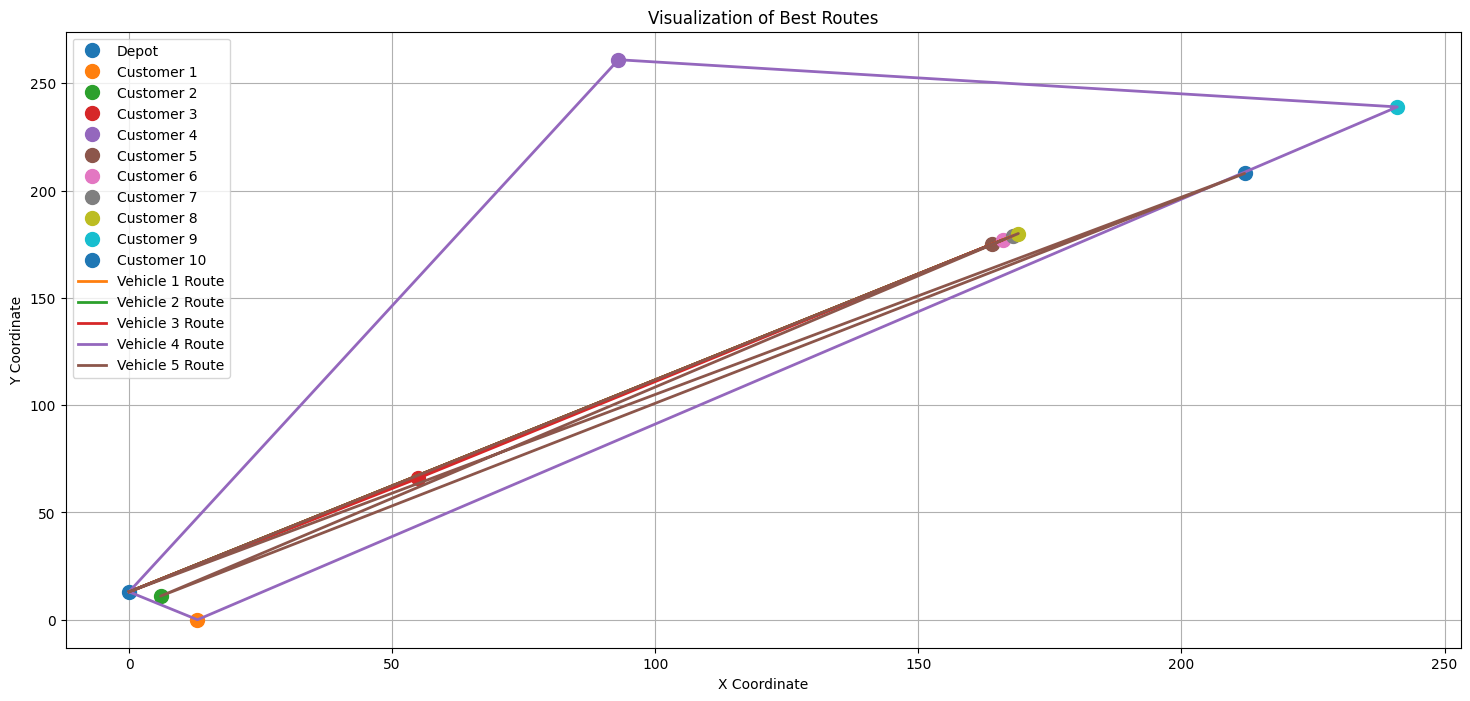

In [ ]:
# plot the routes
def visualize_routes(best_routes, distance_matrix):
    # Plotting the nodes
    plt.figure(figsize=(18, 8))
    for i in range(len(distance_matrix)):
        if i == 0:
            plt.plot(distance_matrix[i][0], distance_matrix[i][1], 'o', markersize=10, label='Depot')
        else:
            plt.plot(distance_matrix[i][0], distance_matrix[i][1], 'o', markersize=10, label=f'Customer {i}')

    # Plotting the routes
    for i, route in enumerate(best_routes):
        if route:
            route_x = [distance_matrix[node - 1][0] for node in route]  # Adjust indexing
            route_y = [distance_matrix[node - 1][1] for node in route]  # Adjust indexing
            plt.plot(route_x, route_y, linestyle='-', linewidth=2, label=f'Vehicle {i+1} Route')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Visualization of Best Routes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize the routes
visualize_routes(best_routes, distance_matrix)
